# Text based
- add label to text
- set anchor text
- cosine similarity
- cross validation/AUC

In [68]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

## Gentrified Texts

In [48]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled_25.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [49]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [50]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()
text_valid["geometry"] = text_valid["wgs84_polygon.coordinates"].apply(lambda coords: Polygon(coords[0]))
# creat GeoDataFrame， set WGS84 coordinate
gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [51]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [52]:
joined = gpd.sjoin(gdf_27700, lsoa_label[["geometry", "gentrified"]], how="left", predicate="within")

In [53]:
print("the percentage of texts being labeled:", joined['gentrified'].notna().mean())

the percentage of texts being labeled: 0.8842856683494646


In [54]:
# check the texts
print("total texts:", len(gdf_27700))
print("text within lsoa:", joined['gentrified'].notna().sum())

total texts: 155495
text within lsoa: 137502


Geometry seems fine, and not all texts are within lsoas, meaning some text polygon cross over more than one lsoas.

Solutions: use the centroid geometry for label

In [55]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [56]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["geometry", "gentrified"]],how="left",predicate="within")

In [57]:
# check the texts again
print("total texts:", len(gdf_27700))
print("text within lsoa:", joined_centroid['gentrified'].notna().sum())

total texts: 155495
text within lsoa: 155367


There's still 128 left, meaning it might happened to be on the boundary of lsoas.
Remove

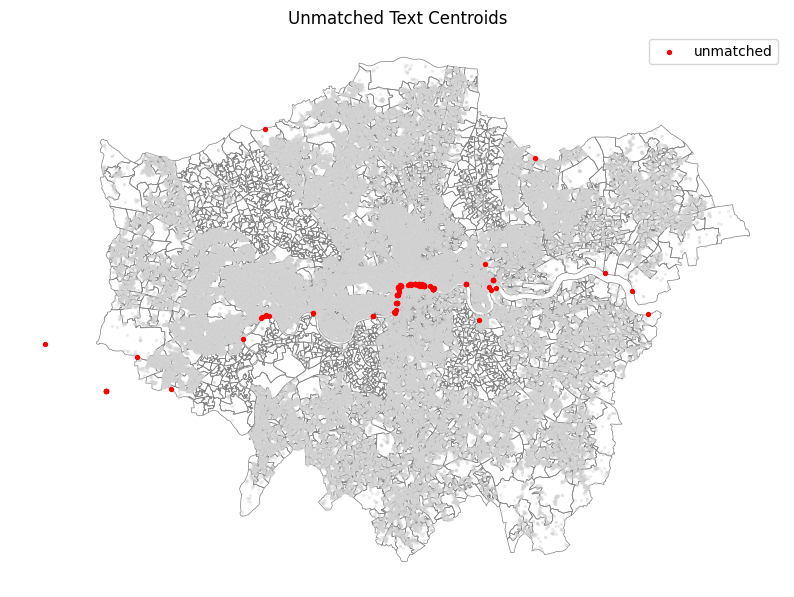

In [58]:
import matplotlib.pyplot as plt

# map the unlabelled points
unmatched = joined_centroid[joined_centroid["gentrified"].isna()]
fig, ax = plt.subplots(figsize=(10, 10))
lsoa_label.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5)
gdf_27700.set_geometry("centroid").plot(ax=ax, color="lightgray", markersize=2, alpha=0.3)
unmatched.set_geometry("centroid").plot(ax=ax, color="red", markersize=8, label="unmatched")


plt.legend()
plt.title("Unmatched Text Centroids")
plt.axis("off")
plt.show()


In [59]:
joined_cleaned = joined_centroid[joined_centroid["gentrified"].notna()].copy()

In [60]:
joined_cleaned.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_378', 'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382',
       'sbert_383', 'geometry', 'centroid', 'index_right', 'gentrified'],
      dtype='object', length=405)

In [61]:
# convert the SBERT list vectors into numpy arrays 
# select all SBERT columns
sbert_cols = [col for col in joined_cleaned.columns if col.startswith("sbert_")]

# combine these columns into a matrix X (with N rows and 384 columns)
X = joined_cleaned[sbert_cols].values 
y = joined_cleaned["gentrified"].astype(int).values

# set train/test, stratify to ensure similar label distribution in the train/test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# initialize the model and handle the imbalance using class_weight
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# prediction and evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     29373
           1       0.09      0.60      0.16      1701

    accuracy                           0.66     31074
   macro avg       0.53      0.63      0.48     31074
weighted avg       0.92      0.66      0.75     31074

AUC Score: 0.6847687109340856


The model has some predicting capabilities (with an AUC value slightly over 0.6), but its ability to predict gentrified = 1 is still insufficient.

## Anchor texts

1. set anchor text, using sbert to encode them

2. perform similarity calculation for each text


In [ ]:
# anchor and encode
# add another typr here: transport/infrusturcture
anchor_dict = {
    "residential": "flat conversion, refurbishment, luxury dwelling",
    "commercial": "coffee shop, gallery, retail unit upgrade",
    "green": "park improvement, landscaping, tree planting",
    "cultural": "artist studios, cultural space, gallery conversion"
}
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
anchor_vecs = {k: sbert_model.encode(v) for k, v in anchor_dict.items()}

this step might take a few hours

In [71]:
# similarity

keyline_text = []       # 提取的关键句
keyline_scores = []     # 最大相似度
keyline_category = []   # 所属的 anchor 类别

for sent_list in tqdm(joined_cleaned['sentences']):
    if len(sent_list) == 0:
        keyline_text.append("")
        keyline_scores.append(0.0)
        keyline_category.append(None)
        continue
    
    sent_vecs = sbert_model.encode(sent_list)  # shape (n, 768)

    best_sim = 0
    best_sent = ""
    best_cat = None

    for cat, anchor_vec in anchor_vecs.items():
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]  # shape (n,)
        idx = np.argmax(sims)
        if sims[idx] > best_sim:
            best_sim = sims[idx]
            best_sent = sent_list[idx]
            best_cat = cat
    
    keyline_text.append(best_sent)
    keyline_scores.append(best_sim)
    keyline_category.append(best_cat)


100%|██████████| 155367/155367 [3:40:48<00:00, 11.73it/s]      


In [74]:
# 加入结果列
joined_cleaned['keyline_text'] = keyline_text
joined_cleaned['keyline_score'] = keyline_scores
joined_cleaned['keyline_category'] = keyline_category
joined_cleaned[['keyline_text', 'keyline_score', 'keyline_category']].head

<bound method NDFrame.head of                                              keyline_text  keyline_score  \
0       Certificate of Lawfulness in connection with e...       0.505189   
1       5 bedroom townhouse with rear garden and 2 x 2...       0.529486   
2       Single storey rear extension with a proposed d...       0.396314   
3       Existing molded sections removed and replaced ...       0.305895   
4       Change of use from Class A1 retail unit to Cla...       0.386526   
...                                                   ...            ...   
192565  Application for certificate of lawfulness in r...       0.181865   
192568  Proposed rear roof extension and patio doors a...       0.414991   
192578  Erection of seven storey building (plus baseme...       0.529036   
192579  Submission of Details Pursuant to Condition No...       0.144957   
192581  Submission of Details Pursuant to Condition No...       0.218636   

       keyline_category  
0           residential  
1    

In [76]:
def iterate_anchor_update(sentences, anchor_vecs, sbert_model, topk=20, max_iter=10, tol=1e-4):
    """
    sentences: list of list-of-sentences（如 joined_cleaned['sentences']）
    anchor_vecs: dict of initial anchor_name: vector
    sbert_model: SBERT model for encoding
    topk: 每类锚提取前 K 个最相似句子
    max_iter: 最大迭代次数
    tol: 收敛阈值
    """
    
    prev_anchor_vecs = {k: v.copy() for k, v in anchor_vecs.items()}
    all_sentences = [sent for sent_list in sentences for sent in sent_list]
    all_sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    for iteration in range(max_iter):
        print(f"\n🔁 Iteration {iteration + 1}")
        updated_vecs = {}
        total_shift = 0.0
        
        for cat in tqdm(anchor_vecs, desc="Updating anchors"):
            sims = cosine_similarity([anchor_vecs[cat]], all_sent_vecs)[0]
            top_idx = np.argsort(sims)[-topk:][::-1]
            top_sent_vecs = all_sent_vecs[top_idx]
            new_vec = np.mean(top_sent_vecs, axis=0)
            
            shift = np.linalg.norm(new_vec - anchor_vecs[cat])
            total_shift += shift
            updated_vecs[cat] = new_vec
        
        print(f"🔍 Mean anchor shift: {total_shift / len(anchor_vecs):.6f}")
        
        # Check convergence
        if total_shift / len(anchor_vecs) < tol:
            print("✅ Converged.")
            break
        
        anchor_vecs = updated_vecs

    return anchor_vecs


In [77]:
updated_anchor_vecs = iterate_anchor_update(
    sentences=joined_cleaned['sentences'],
    anchor_vecs=anchor_vecs,
    sbert_model=sbert_model,
    topk=20,
    max_iter=10,
    tol=1e-4
)

Batches:   0%|          | 0/6845 [00:00<?, ?it/s]


🔁 Iteration 1


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


🔍 Mean anchor shift: 4.726588

🔁 Iteration 2


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


🔍 Mean anchor shift: 2.264821

🔁 Iteration 3


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


🔍 Mean anchor shift: 0.586837

🔁 Iteration 4


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


🔍 Mean anchor shift: 0.352231

🔁 Iteration 5


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


🔍 Mean anchor shift: 0.270406

🔁 Iteration 6


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


🔍 Mean anchor shift: 0.114687

🔁 Iteration 7


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


🔍 Mean anchor shift: 0.113725

🔁 Iteration 8


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


🔍 Mean anchor shift: 0.098606

🔁 Iteration 9


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


🔍 Mean anchor shift: 0.173988

🔁 Iteration 10


Updating anchors: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

🔍 Mean anchor shift: 0.168626


In [81]:
def extract_topk_sentences_per_anchor(anchor_vecs, all_sentences, sbert_model, topk=10):
    """
    返回每个 anchor 类别对应的 top-k 最相关句子
    """
    print(f"\n📌 Extracting top-{topk} sentences per anchor...")

    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    anchor_top_sentences = {}

    for cat, anchor_vec in anchor_vecs.items():
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]
        sorted_idx = np.argsort(sims)[::-1]  # 从大到小

        seen = set()
        top_sents = []

        for i in sorted_idx:
            sent = all_sentences[i]
            if sent not in seen:
                seen.add(sent)
                top_sents.append(sent)
            if len(top_sents) >= topk:
                break

        anchor_top_sentences[cat] = top_sents

    return anchor_top_sentences

In [82]:
# 所有句子展开
all_sents = [sent for sent_list in joined_cleaned['sentences'] for sent in sent_list]

# 提取每个 anchor 类别的 top-k 相似句
top_sents_per_anchor = extract_topk_sentences_per_anchor(
    anchor_vecs=updated_anchor_vecs,
    all_sentences=all_sents,
    sbert_model=sbert_model,
    topk=10  # 可设成 20、50 等
)


📌 Extracting top-10 sentences per anchor...


Batches:   0%|          | 0/6845 [00:00<?, ?it/s]

In [ ]:
for cat, sents in top_sents_per_anchor.items():
    print(f"\n=== {cat} ===")
    for i, sent in enumerate(sents, 1):
        print(f"{i}. {sent}")


=== residential ===
1. Conversion of existing dwelling into 2no self-contained flats.
2. Conversion of the existing dwelling into 2no self-contained flats.
3. Conversion of an existing dwelling into 2no self-contained flats.
4. Conversion of existing dwelling to 2no self contained flats.
5. Conversion of existing dwelling into 2no self-contained flats
6. Conversion of existing dwelling into 2no self contained flats
7. Conversion of an existing dwelling into 2no self-contained flats
8. Conversion of the existing dwelling into 2no self-contained flats
9. Conversion of existing dwelling into 2no self-contained flats (Part retrospective)
10. Conversion of existing dwelling into 2no self-contained flats (Retrospective Application)

=== commercial ===
1. Installation of a new shopfront.
2. Installation of new shopfront.
3. Installation of a new shopfront
4. Installation of new shopfronts.
5. Installation of a shopfront.
6. Installation of new shopfront
7. INSTALLATION OF NEW SHOPFRONT
8. In

: 